In [1]:
import os, glob, cv2
import numpy as np
import pandas as pd

In [2]:
!pip install -q efficientnet 

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

In [5]:
SEED = 42
EPOCHS = 100
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256



In [6]:
IMG_ROOT = 'input/cataract_dataset/dataset'
IMG_DIR = [os.path.join(IMG_ROOT,'1_normal'), 
           os.path.join(IMG_ROOT,'2_cataract'), 
           os.path.join(IMG_ROOT,'2_glaucoma'), 
           os.path.join(IMG_ROOT,'3_retina_disease')]

In [7]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(42)

In [8]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [9]:
cat_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'cataract'],
                  index=range(601))

filepaths=glob.glob(os.path.join('input/cataract_dataset/dataset*/*/*.png'))


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
    if filepath[0] == 'input\cataract_dataset\dataset\1_normal':    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == 'input\cataract_dataset\dataset\2_cataract':  # cataract
        cat_df.iloc[i, 1] = 1
    elif filepath[0] == 'input\cataract_dataset\dataset\2_glaucoma':  # glaucoma
        cat_df.iloc[i, 1] = 2
    elif filepath[0] == 'input\cataract_dataset\dataset\3_retina':  # retine_disease
        cat_df.iloc[i, 1] = 3
        
cat_df=cat_df.query('0 <= cataract < 2')
print(cat_df)

                                                 paths  cataract
0    input/cataract_dataset\dataset\1_normal/NL_001...         0
1    input/cataract_dataset\dataset\1_normal/NL_002...         0
2    input/cataract_dataset\dataset\1_normal/NL_003...         0
3    input/cataract_dataset\dataset\1_normal/NL_004...         0
4    input/cataract_dataset\dataset\1_normal/NL_005...         0
..                                                 ...       ...
596  input/cataract_dataset\dataset\3_retina_diseas...         0
597  input/cataract_dataset\dataset\3_retina_diseas...         0
598  input/cataract_dataset\dataset\3_retina_diseas...         0
599  input/cataract_dataset\dataset\3_retina_diseas...         0
600  input/cataract_dataset\dataset\3_retina_diseas...         0

[601 rows x 2 columns]


In [10]:
cat_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'cataract'],
                  index=range(399))

filepaths=glob.glob(os.path.join('input/cataract_dataset/dataset/1_normal/*.png'))
filepaths2=glob.glob(os.path.join('input/cataract_dataset/dataset/2_cataract/*.png'))
i=0;
for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    cat_df.iloc[i, 1] = 0

for i2, filepath in enumerate(filepaths2):
    filepath = os.path.split(filepath)
    cat_df.iloc[i+i2, 0] = filepath[0] + '/' + filepath[1]
    cat_df.iloc[i+i2, 1] = 1
        

print(cat_df)

                                                 paths  cataract
0    input/cataract_dataset/dataset/1_normal/NL_001...         0
1    input/cataract_dataset/dataset/1_normal/NL_002...         0
2    input/cataract_dataset/dataset/1_normal/NL_003...         0
3    input/cataract_dataset/dataset/1_normal/NL_004...         0
4    input/cataract_dataset/dataset/1_normal/NL_005...         0
..                                                 ...       ...
394  input/cataract_dataset/dataset/2_cataract/cata...         1
395  input/cataract_dataset/dataset/2_cataract/cata...         1
396  input/cataract_dataset/dataset/2_cataract/cata...         1
397  input/cataract_dataset/dataset/2_cataract/cata...         1
398  input/cataract_dataset/dataset/2_cataract/cata...         1

[399 rows x 2 columns]


In [11]:
cat_df.iloc[0,0]

'input/cataract_dataset/dataset/1_normal/NL_001.png'

In [12]:
#for i, filepath in enumerate(filepaths):
    #filepath = os.path.split(filepath)
  #  print(filepath[0],'/',filepath[1])

In [13]:
#for dir in os.listdir('input/cataract_dataset/dataset/'):
 #   print(dir)

In [14]:
#filepath=glob.glob(os.path.join('input/cataract_dataset/dataset*/*/*.png'))

In [15]:
print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts())

Number of normal and cataract images
0    299
1    100
Name: cataract, dtype: int64


In [16]:
##training split
train_df, test_df = train_test_split(cat_df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=cat_df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [17]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df


In [18]:
train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:15<00:00,  5.12it/s]


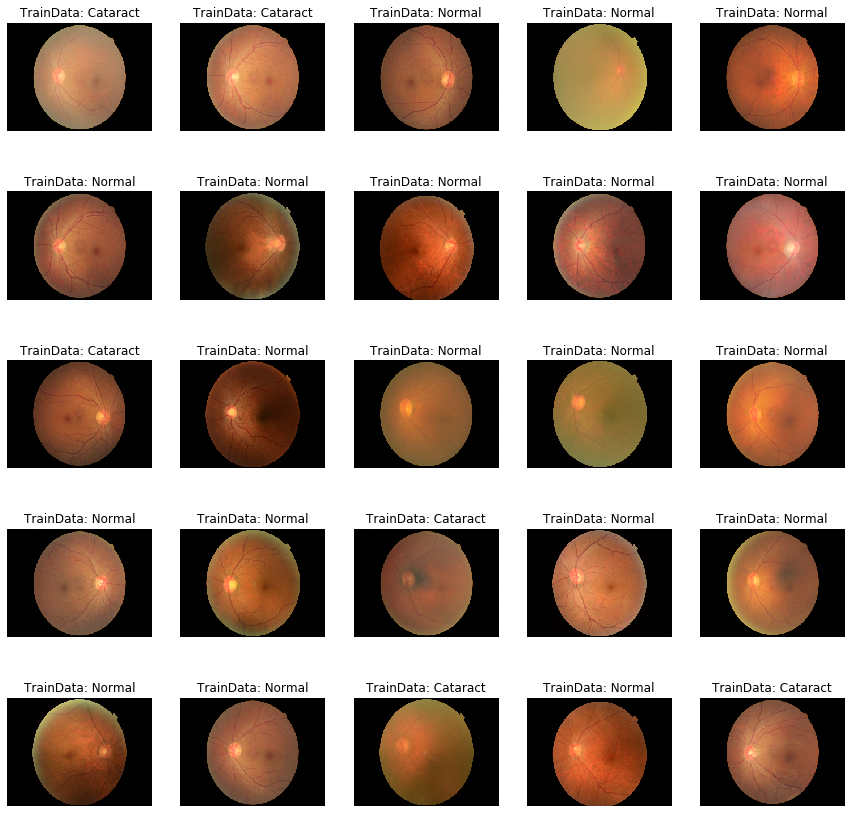

In [19]:
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][25:50])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.savefig('train_img.png')
plt.show()


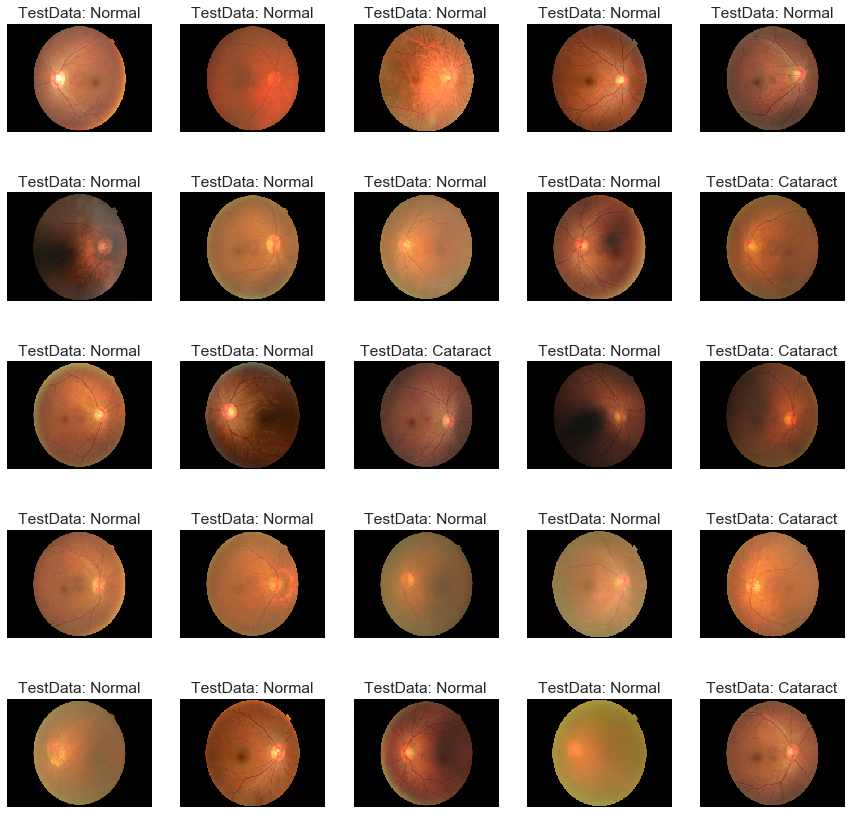

In [98]:
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][25:50])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.savefig('test_images.png')
plt.show()


In [21]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model=tf.keras.models.Sequential([tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
                                  
                                 tf.keras.layers.MaxPool2D(2,2),
                                  tf.keras.layers.Dropout(0.2),
                                  
                                  #
                                 tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
                                 tf.keras.layers.MaxPool2D(2,2),
                                  tf.keras.layers.Dropout(0.2),
                                 #
                                  tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
                                 tf.keras.layers.MaxPool2D(2,2),
                                  tf.keras.layers.Dropout(0.2),
                                 
                                 tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
                                 tf.keras.layers.MaxPool2D(2,2),
                                  tf.keras.layers.Dropout(0.2),
                                  
                                  
                                  #
                                  
                                  #
                                 tf.keras.layers.Flatten(),
                                 #
                                  tf.keras.layers.Dense(256,activation='relu'),
                                  #
                                  tf.keras.layers.Dense(64,activation='relu'),
                                  tf.keras.layers.Dense(16,activation='relu'),
                                  tf.keras.layers.Dense(2,activation='softmax')])

In [22]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 127, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 95, 127, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 125, 128)      73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 62, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 60, 128)       1

In [24]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.15,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/25
9/8 [===============================] - 36s 4s/step - loss: 0.6720 - accuracy: 0.6900 - val_loss: 0.5805 - val_accuracy: 0.7500
Epoch 2/25
9/8 [===============================] - 34s 4s/step - loss: 0.6420 - accuracy: 0.7491 - val_loss: 0.6397 - val_accuracy: 0.7500
Epoch 3/25
9/8 [===============================] - 34s 4s/step - loss: 0.5834 - accuracy: 0.7491 - val_loss: 0.5714 - val_accuracy: 0.7500
Epoch 4/25
9/8 [===============================] - 36s 4s/step - loss: 0.5692 - accuracy: 0.7491 - val_loss: 0.5959 - val_accuracy: 0.7500
Epoch 5/25
9/8 [===============================] - 34s 4s/step - loss: 0.5725 - accuracy: 0.7491 - val_loss: 0.5791 - val_accuracy: 0.7500
Epoch 6/25
9/8 [===============================] - 33s 4s/step - loss: 0.5809 - accuracy: 0.7491 - val_loss: 0.5691 - val_accuracy: 0.7500
Epoch 7/25
9/8 [===============================] - 35s 4s/step - loss: 0.5587 - accuracy: 0.7491 - val_loss: 0.5613 - val_accuracy: 0.7500
Epoch 8/25
9/8 [===========

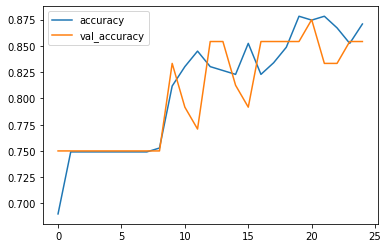

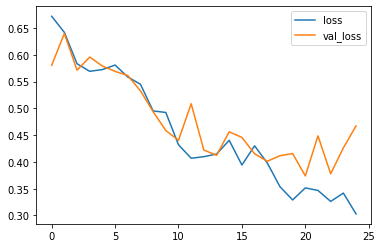

In [25]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=25,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [26]:
model.evaluate(test_imgs, test_df) ##test loss and accuracy

3/3 [==============================] - 2s 620ms/step - loss: 0.4263 - accuracy: 0.8625


[0.4262714385986328, 0.862500011920929]

In [27]:
len(test_imgs)

80

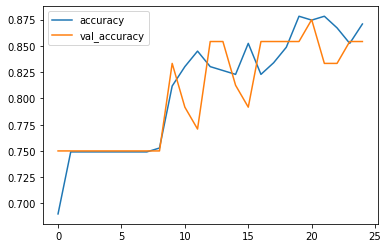

In [28]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.savefig('accuracy.png')
plt.show()


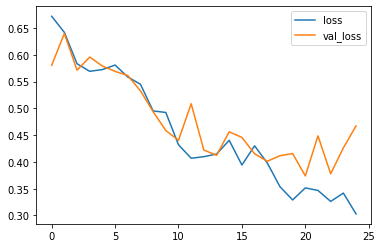

In [29]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.savefig('loss.png')
plt.show()


In [30]:
type(history)

tensorflow.python.keras.callbacks.History

In [31]:
print(pd.DataFrame(history.history))

        loss  accuracy  val_loss  val_accuracy     lr
0   0.672043  0.690037  0.580497      0.750000  0.001
1   0.641965  0.749077  0.639688      0.750000  0.001
2   0.583369  0.749077  0.571366      0.750000  0.001
3   0.569198  0.749077  0.595854      0.750000  0.001
4   0.572475  0.749077  0.579060      0.750000  0.001
5   0.580888  0.749077  0.569147      0.750000  0.001
6   0.558694  0.749077  0.561326      0.750000  0.001
7   0.545005  0.749077  0.532781      0.750000  0.001
8   0.495232  0.752768  0.493940      0.750000  0.001
9   0.492368  0.811808  0.458569      0.833333  0.001
10  0.432035  0.830258  0.440383      0.791667  0.001
11  0.406869  0.845018  0.508603      0.770833  0.001
12  0.409784  0.830258  0.422204      0.854167  0.001
13  0.414719  0.826568  0.412337      0.854167  0.001
14  0.440316  0.822878  0.456263      0.812500  0.001
15  0.394244  0.852399  0.445751      0.791667  0.001
16  0.430088  0.822878  0.415329      0.854167  0.001
17  0.398181  0.833948  0.40

In [32]:
new_y_pred=model.predict(test_imgs)

In [48]:
predict=[]
for i in new_y_pred:
    if(i[0]<=0.5):
        predict.append(0)
    else:
        predict.append(1)

In [51]:
print(test_df[1])
test_yu=test_df[0].values

102    0
252    0
220    0
1      0
160    0
      ..
163    0
396    1
362    1
169    0
121    0
Name: 1, Length: 80, dtype: uint8


In [50]:
from sklearn.metrics import f1_score

In [52]:
f1_score(test_yu,predict)

0.912

In [58]:
import seaborn as sns

In [55]:
from sklearn.metrics import confusion_matrix

In [56]:
new_cm=confusion_matrix(test_yu,predict)

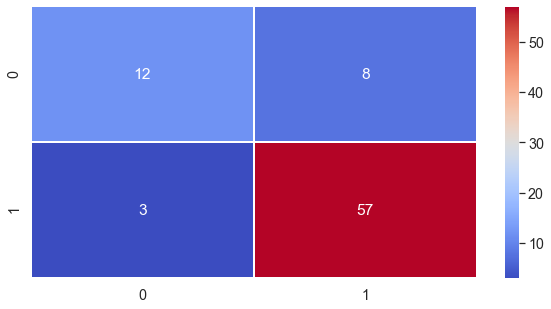

In [99]:
df=pd.DataFrame(new_cm,index=(0,1),columns=(0,1))
plt.figure(figsize=(10,5))
sns.set(font_scale=1.3)
image_hm=sns.heatmap(df, annot=True,cmap='coolwarm', linecolor='white', linewidths=1)

In [130]:
n,x,y,z=train_imgs.shape
d2_train_imgs=train_imgs.reshape(n,x*y*z)

In [138]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(n, x*y*z))

ValueError: `input_shape` must be a tuple of three integers.

In [139]:
for layer in vgg.layers:
    layer.trainable = False

In [140]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [141]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 4608, 512)      20024384  
_________________________________________________________________
flatten_4 (Flatten)          (None, 18874368)          0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 18874369  
Total params: 38,898,753
Trainable params: 18,874,369
Non-trainable params: 20,024,384
_________________________________________________________________


In [142]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [143]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [144]:
##train_imgs_224=train_imgs.reshape(224,224)
n,x,y,z=train_imgs.shape
d2_train_imgs=train_imgs.reshape(n,x*y*z)

In [148]:
n,x,y,z=val_imgs.shape
d2_val_imgs=val_imgs.reshape(n,x*y*z)

In [149]:
history = model.fit(d2_train_imgs, train_df,batch_size=32,epochs=15,validation_data=(val_imgs,val_df))

Epoch 1/15


ValueError: in user code:

    C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer block1_conv1 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: [None, 147456]


In [61]:
val_imgs.shape

(48, 192, 256, 3)

In [63]:
train_imgs.shape

(271, 192, 256, 3)

SVM

In [62]:
train_imgs.shape

(271, 192, 256, 3)

In [78]:

X= train_imgs.reshape(271,-1)

In [80]:
train_df.shape

(271, 2)

In [81]:
y=train_df[0].values

In [82]:
y.shape

(271,)

In [83]:
from sklearn.svm import SVC
svc = SVC(kernel='linear',gamma='auto')
svc.fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [86]:
X_test_u= test_imgs.reshape(80,-1)
y_test_u=test_df[0].values

In [88]:
y2 = svc.predict(X_test_u)

In [90]:
from sklearn.metrics import accuracy_score
print("Accuracy on data is",accuracy_score(y_test_u,y2))

Accuracy on data is 0.875


In [91]:
f1_score(y_test_u,y2)

0.9137931034482758

In [92]:
new_cm_svm=confusion_matrix(y_test_u,y2)

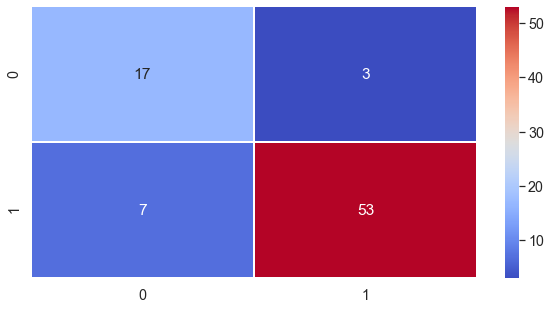

In [95]:
df=pd.DataFrame(new_cm_svm,index=(0,1),columns=(0,1))
plt.figure(figsize=(10,5))
sns.set(font_scale=1.3)
image_hm=sns.heatmap(df, annot=True,cmap='coolwarm', linecolor='white', linewidths=1)

In [96]:
pd.DataFrame(svc.history)[['accuracy', 'val_accuracy']].plot()
plt.savefig('accuracy_svm.png')
plt.show()

AttributeError: 'SVC' object has no attribute 'history'